In [1]:
import pandas as pd
data = pd.read_csv(
    "all-data.csv",
    encoding="latin1",
    header=None)

data.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [2]:
data.columns = ['label', 'sentence']

In [3]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to C:\Users\USER
[nltk_data]     HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:


class TextPreprocessor:
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def expand_contractions(self, text):
        text = text.replace("n't", " not")
        text = text.replace("'re", " are")
        text = text.replace("'s", "")
        return text
    
    def remove_special_chars(self, text):
        return re.sub(r'[^a-zA-Z0-9\. ]', ' ', text)
    
    def tokenize(self, text):
        return word_tokenize(text)
    
    def remove_stopwords(self, tokens):
        return [t for t in tokens if t not in self.stop_words]
    
    def stem(self, tokens):
        return [self.stemmer.stem(t) for t in tokens]
    
    def lemmatize(self, tokens):
        return [self.lemmatizer.lemmatize(t) for t in tokens]
    
    def preprocess(self, text, use_lemmatization=False):
        text = text.lower()
        text = self.expand_contractions(text)
        text = self.remove_special_chars(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        
        if use_lemmatization:
            tokens = self.lemmatize(tokens)
        else:
            tokens = self.stem(tokens)
            
        return tokens



In [5]:

tp = TextPreprocessor()

data['processed_text'] = data['sentence'].apply(
    lambda x: " ".join(tp.preprocess(x, use_lemmatization=True))
)

data[['sentence', 'processed_text']].head()


,sentence,processed_text
0,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less 100 0...
2,The international electronic industry company ...,international electronic industry company elco...
3,With the new production plant the company woul...,new production plant company would increase ca...
4,According to the company 's updated strategy f...,according company updated strategy year 2009 2...


In [6]:
!pip install vaderSentiment textblob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import numpy as np



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
class LexiconSentimentAnalyzer:
    
    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()
        
        self.custom_lexicon = {
            'profit': 1, 'growth': 1, 'gain': 1, 'surge': 1,
            'loss': -1, 'decline': -1, 'fall': -1, 'drop': -1,
            'strong': 1, 'weak': -1, 'beat': 1, 'miss': -1,
            'positive': 1, 'negative': -1, 'risk': -1,
            'increase': 1, 'decrease': -1, 'bullish': 1,
            'bearish': -1, 'record': 1
        }
    
    def vader_sentiment(self, text):
        score = self.vader.polarity_scores(text)['compound']
        label = 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
        return score, label
    
    def textblob_sentiment(self, text):
        polarity = TextBlob(text).sentiment.polarity
        label = 'positive' if polarity > 0 else 'negative' if polarity < 0 else 'neutral'
        return polarity, label
    
    def custom_lexicon_sentiment(self, text):
        score = 0
        for word in text.lower().split():
            score += self.custom_lexicon.get(word, 0)
        return np.tanh(score)  # normalize to [-1, 1]
    
    def analyze(self, text):
        vader_score, vader_label = self.vader_sentiment(text)
        tb_score, tb_label = self.textblob_sentiment(text)
        custom_score = self.custom_lexicon_sentiment(text)
        
        ensemble = np.mean([vader_score, tb_score, custom_score])
        
        return {
            'text': text,
            'vader': {'compound': vader_score, 'label': vader_label},
            'textblob': {'polarity': tb_score, 'label': tb_label},
            'custom_score': custom_score,
            'ensemble_score': ensemble,
            'confidence': abs(ensemble)
        }

In [8]:
analyzer = LexiconSentimentAnalyzer()

data['sentiment_score'] = data['processed_text'].apply(
    lambda x: analyzer.analyze(x)['ensemble_score']
)


In [9]:
def score_to_label(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

data['predicted_label'] = data['sentiment_score'].apply(score_to_label)

data[['sentence', 'label', 'predicted_label']].head()


,sentence,label,predicted_label
0,"According to Gran , the company has no plans t...",neutral,positive
1,Technopolis plans to develop in stages an area...,neutral,negative
2,The international electronic industry company ...,negative,negative
3,With the new production plant the company woul...,positive,positive
4,According to the company 's updated strategy f...,positive,positive


In [10]:
from sklearn.metrics import classification_report

print(classification_report(
    data['label'],
    data['predicted_label']
))


              precision    recall  f1-score   support

    negative       0.39      0.35      0.37       604
     neutral       0.74      0.46      0.57      2879
    positive       0.39      0.73      0.51      1363

    accuracy                           0.52      4846
   macro avg       0.51      0.51      0.48      4846
weighted avg       0.60      0.52      0.52      4846



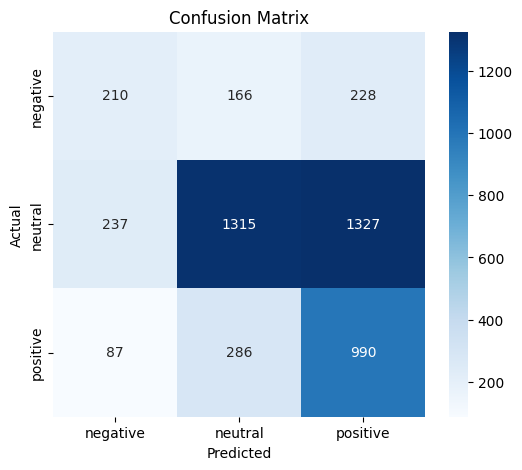

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(data['label'], data['predicted_label'])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['negative', 'neutral', 'positive'],
    yticklabels=['negative', 'neutral', 'positive']
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
